In [10]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [0]:
#export
import operator

def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

In [0]:
#export
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import pandas as pd

In [0]:
# Plus 10 data
train_url = 'https://raw.githubusercontent.com/Ghost-8D/thesis_project/master/PSSP_Playground/datasetsPlus10/trainSet0.txt'
test_url = 'https://raw.githubusercontent.com/Ghost-8D/thesis_project/master/PSSP_Playground/datasetsPlus10/testSet0.txt'

In [14]:
! mkdir pssp_model
! ls

pssp_model  sample_data


In [15]:
path = Path('/pssp_model')
path.mkdir(parents=True, exist_ok=True)
path

PosixPath('/pssp_model')

In [0]:
def get_data():
    df_train = pd.read_csv(train_url, header=None)
    df_valid = pd.read_csv(test_url, header=None)
    def get_XY_from_df(df):
        x = df.values[:, :-1]
        y = df.values[:, TOTAL_COLS-1]
        return x, y
    x_train, y_train = get_XY_from_df(df_train)
    x_valid, y_valid = get_XY_from_df(df_valid)
    x_train, y_train, x_valid, y_valid = map(tensor, (x_train, y_train, x_valid, y_valid))
    return x_train.float(), y_train, x_valid.float(), y_valid

def normalize(x, m, s): return (x-m)/s

In [17]:
NEIGHBOURS = 10 # 1 amino-acid left and 1 amino-acid right added 
AMINO_ACID_LEN = 20
WINDOW = 2 * NEIGHBOURS + 1
TOTAL_AMINO_ACIDS = WINDOW * AMINO_ACID_LEN
TOTAL_COLS = TOTAL_AMINO_ACIDS + 1 # plus the secondary structure category
CATEGORIES = 3
TOTAL_COLS

421

In [18]:
x_train, y_train, x_valid, y_valid = get_data()
n,c = x_train.shape
x_train, x_train.shape, y_train, y_train.shape, y_train.min(), y_train.max()

(tensor([[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         ...,
         [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
         [ 0.,  1.,  0.,  ...,  0.,  0.,  0.],
         [18., 10., 64.,  ...,  0.,  0.,  0.]]),
 torch.Size([77092, 420]),
 tensor([0, 0, 1,  ..., 1, 0, 0]),
 torch.Size([77092]),
 tensor(0),
 tensor(2))

In [0]:
assert n==y_train.shape[0]==77092
test_eq(c, WINDOW * AMINO_ACID_LEN)
test_eq(y_train.min(),0)
test_eq(y_train.max(),2)

In [20]:
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape

(torch.Size([77092, 420]),
 torch.Size([77092]),
 torch.Size([7289, 420]),
 torch.Size([7289]))

In [21]:
mpl.rcParams['image.cmap'] = 'cool'
img = x_train[0]
img.view(WINDOW, AMINO_ACID_LEN).type()

'torch.FloatTensor'

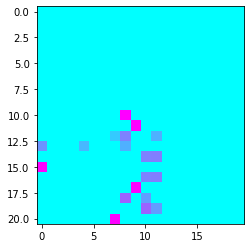

In [22]:
plt.imshow(img.view((21,20)));

In [23]:
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(tensor(4.7987), tensor(11.2503))

In [0]:
def normalize(x, m, s): return (x-m)/s

In [0]:
x_train = normalize(x_train, train_mean, train_std)
# NOTE: Use training, not validation mean for validation set
x_valid = normalize(x_valid, train_mean, train_std)

In [26]:
train_mean, train_std = x_train.mean(), x_train.std()
train_mean, train_std

(tensor(-4.1988e-05), tensor(1.))

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import numpy as np

In [0]:
class Module():
    def __call__(self, *args):
        self.args = args
        self.out = self.forward(*args)
        return self.out
    
    def forward(self): raise Exception('not implemented')
    def backward(self): self.bwd(self.out, *self.args)

In [0]:
class Lin(Module):
    def __init__(self, w, b): 
        super().__init__()
        self.w,self.b = w,b
    
    def forward(self, inp): return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.t()
        self.w.g = inp.t() @ out.g
        self.b.g = out.g.sum(0)

In [0]:
class Relu(Module):
    def __init__(self): super().__init__()
    def forward(self, inp): return torch.clamp(inp, 0, 1e10) #return inp.clamp_min(0.)-0.5
    def bwd(self, out, inp): return out == inp #inp.g = (inp>0).float() * out.g

In [0]:
class Model():
    def __init__(self, n_in, nh, n_out):
        self.layers = nn.ModuleList([Lin(n_in, nh), Relu(), Lin(nh, n_out)])
        self.loss = nn.CrossEntropyLoss()
        
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward()

In [0]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out), nn.ReLU()]
        self.loss = nn.CrossEntropyLoss()
        self.params = [torch.randn(n_in, nh) * math.sqrt(2.0/n_in),
                           torch.randn(nh),
                           torch.randn(nh, n_out) * math.sqrt(2.0/nh),
                           torch.randn(n_out)]
        
    def __call__(self, x):
        self.activations = []
        self.d_activations = []
        for l in self.layers: 
            out_x = l(x)
            if (isinstance(l, type(nn.ReLU()))):
                self.activations.append(x)
                self.d_activations.append(x == out_x)
            x = out_x
        return x 

    def parameters(self):
        return self.params

In [0]:
def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

In [0]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr
        
    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [0]:
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [0]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

In [0]:
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c
        
    @property
    def train_ds(self): return self.train_dl.dataset
        
    @property
    def valid_ds(self): return self.valid_dl.dataset

In [0]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)
nh,bs = 50, 78000
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [40]:
model = nn.Sequential(nn.Linear(420,50), nn.ReLU(), nn.Linear(50,3))
model.parameters()

<generator object Module.parameters at 0x7f28fc4deeb8>

In [0]:
def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, data.c)) #Model(m, nh, data.c) 
    return model, optim.SGD(model.parameters(), lr=lr) #HessianFree(model.parameters(), CG_iter=100, init_damping=20, net=model)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

In [0]:
learn = Learner(*get_model(data), loss_func, data)

In [0]:
def fit(epochs, learn):
    for epoch in range(epochs):
        learn.model.train()
        for xb,yb in learn.data.train_dl:
            loss = learn.loss_func(learn.model(xb), yb)
            loss.backward()
            learn.opt.step()
            learn.opt.zero_grad()

        learn.model.eval()
        with torch.no_grad():
            tot_loss,tot_acc = 0.0, 0.0
            for xb,yb in learn.data.valid_dl:
                pred = learn.model(xb)
                tot_loss += learn.loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(learn.data.valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
    return tot_loss/nv, tot_acc/nv

In [44]:
loss,acc = fit(10, learn)

0 tensor(62.5205) tensor(0.2456)
1 tensor(3.6233) tensor(0.4752)
2 tensor(1.1012) tensor(0.3315)
3 tensor(1.0922) tensor(0.3349)
4 tensor(1.0859) tensor(0.3383)
5 tensor(1.0811) tensor(0.3411)
6 tensor(1.0775) tensor(0.3489)
7 tensor(1.0744) tensor(0.4276)
8 tensor(1.0709) tensor(0.4276)
9 tensor(1.0649) tensor(0.4276)


In [0]:
import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')
def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')

In [0]:
class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

In [0]:
from typing import *
from functools import partial

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, str): return [o]
    if isinstance(o, Iterable): return list(o)
    return [o]

In [0]:
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        self.xb,self.yb = xb,yb
        if self('begin_batch'): return
        self.pred = self.model(self.xb)
        if self('after_pred'): return
        self.loss = self.loss_func(self.pred, self.yb)
        if self('after_loss') or not self.in_train: return
        self.loss.backward()
        if self('after_backward'): return
        self.opt.step()
        if self('after_step'): return
        self.opt.zero_grad()

    def all_batches(self, dl):
        self.iters = len(dl)
        for xb,yb in dl:
            if self.stop: break
            self.one_batch(xb, yb)
            self('after_batch')
        self.stop=False

    def fit(self, epochs, learn):
        self.epochs,self.learn = epochs,learn

        try:
            for cb in self.cbs: cb.set_runner(self)
            if self('begin_fit'): return
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                if self('after_epoch'): break
            
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        for cb in sorted(self.cbs, key=lambda x: x._order):
            f = getattr(cb, cb_name, None)
            if f and f(): return True
        return False

In [0]:
class AvgStats():
    def __init__(self, metrics, in_train): self.metrics,self.in_train = listify(metrics),in_train
    
    def reset(self):
        self.tot_loss,self.count = 0.,0
        self.tot_mets = [0.] * len(self.metrics)
        
    @property
    def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
    @property
    def avg_stats(self): return [o/self.count for o in self.all_stats]
    
    def __repr__(self):
        if not self.count: return ""
        return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"

    def accumulate(self, run):
        bn = run.xb.shape[0]
        self.tot_loss += run.loss * bn
        self.count += bn
        for i,m in enumerate(self.metrics):
            self.tot_mets[i] += m(run.pred, run.yb) * bn

class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

In [0]:
def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

In [0]:
def get_model_func(lr=0.5): return partial(get_model, lr=lr)

In [0]:
class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

In [0]:
def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

In [0]:
@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def cos_1cycle_anneal(start, high, end):
    return [sched_cos(start, high), sched_cos(high, end)]

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))

In [0]:
def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner

In [0]:
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [0]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x): return x.view(x.shape[0], -1)

In [0]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(pssp_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [0]:
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [0]:
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [0]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [0]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [0]:
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = F.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [64]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]
cbfs.append(CudaCallback)
pssp_view = view_tfm(1,21,20)
cbfs.append(partial(BatchTransformXCallback, pssp_view))
nfs = [8,16,32,32]
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.4, cbs=cbfs)
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (4): AdaptiveAvgPool2d(output_size=1)
  (5): Lambda()
  (6): Linear(in_features=32, out_features=3, bias=True)
)

In [65]:
run.fit(3, learn)

train: [1.1092852127976962, tensor(0.3497, device='cuda:0')]
valid: [1.09547951643744, tensor(0.3276, device='cuda:0')]
train: [1.091418268918954, tensor(0.3496, device='cuda:0')]
valid: [1.0856582907463301, tensor(0.3520, device='cuda:0')]
train: [1.0810746008016396, tensor(0.3764, device='cuda:0')]
valid: [1.0792824322180683, tensor(0.4223, device='cuda:0')]


In [0]:
class Lin(nn.Module):
    __constants__ = ['bias', 'in_features', 'out_features']

    def __init__(self, in_features, out_features, bias=True):
        super(Lin, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input, new_params=None, new_bias=None):
        if new_params is not None and new_bias is not None:
            F.linear(input, new_params, new_bias)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

In [0]:
toy_x_train = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
toy_y_train = np.array([0, 1, 1, 0])
toy_x_valid = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
toy_y_valid = np.array([0, 1, 1, 0])
toy_x_train, toy_y_train, toy_x_valid, toy_y_valid = torch.from_numpy(toy_x_train).float(), torch.from_numpy(toy_y_train), torch.from_numpy(toy_x_valid).float(), torch.from_numpy(toy_y_valid)
toy_train_ds,toy_valid_ds = Dataset(toy_x_train, toy_y_train),Dataset(toy_x_valid, toy_y_valid)
toy_nh, toy_bs = 120, 4
toy_c = toy_y_train.max().item()+1
loss_func = F.cross_entropy
toy_data = DataBunch(*get_dls(toy_train_ds, toy_valid_ds, toy_bs), toy_c)

In [0]:
# new_y_train = []
# for i in range(0, len(y_train)):
#     temp = [0, 0, 0]
#     temp[y_train[i].item()] = 1
#     new_y_train.append(temp)
# new_y_train = np.array(new_y_train)
# new_y_train = torch.from_numpy(new_y_train)
# new_y_train, y_train

In [0]:
# def get_loss(output, targets):
#     expand_targets = torch.zeros_like(output)
#     for i in range(0, len(expand_targets)): expand_targets[i][targets[i]] = 1
#     # return torch.sum((output - expand_targets) * (output - expand_targets)) / (2.0 * output.shape[0])
#     # temp = -np.sum(np.nan_to_num(targets) * np.log(1e-15 + output[-1]))
#     return -torch.sum(expand_targets * torch.log(output))

# def d_loss(output, targets):
#     expand_targets = torch.zeros_like(output)
#     for i in range(0, len(expand_targets)): expand_targets[i][targets[i]] = 1
#     return -(expand_targets) / (output)

def d2_loss(output, targets):
    # return torch.ones_like(output)
    # print(output.shape, targets.shape)
    return torch.sum(torch.diag_embed(output, offset=0, dim1=-2, dim2=-1) - 
                     output.unsqueeze(-1) @ output.unsqueeze(1), 1)
    # print(output.unsqueeze(-1).shape, output.unsqueeze(1).shape)
    # print(output.shape, targets.shape)
    # print(torch.diag_embed(output, offset=0, dim1=-2, dim2=-1))
    # print((output.unsqueeze(-1) @ output.unsqueeze(1)).shape)
    # print(targets / (output ** 2))
    expand_targets = torch.zeros_like(output)
    for i in range(0, len(expand_targets)): expand_targets[i][targets[i]] = 1
    # print(expand_targets + 1e-8 / ((output) ** 2 + 1e-8))
    return (expand_targets / ((output) ** 2 )).t()

def make_flat_v1(tensor_list):
    temp = []
    for c in range(0, len(tensor_list), 2):
        temp.append(tensor_list[c].t().flatten())
    for c in range(1, len(tensor_list), 2):
        temp.append(tensor_list[c].t().flatten())
    return torch.cat(temp, dim=0)

def make_flat(tensor_list):
    temp = []
    for c in range(0, len(tensor_list)):
        temp.append(tensor_list[c].view(-1))
    return torch.cat(temp, dim=0)

def calc_accuracy(out, yb): 
    # print(out.shape, yb.shape)
    # print(out[:10])
    # print(yb[:10])
    return (torch.argmax(out, dim=1)==torch.argmax(yb, dim=1)).float().mean()

def inner_product(arr1, arr2):
    # if len(arr1) != len(arr2): return None
    product = 0.0
    for i,j in zip(arr1, arr2):
        product += torch.matmul(i.view(-1), j.view(-1))
    return product

def J_dot(J, vec, transpose_J=False, out=None):
    """Compute the product of a Jacobian and some vector."""

    if J.ndim == 2:
        # note: the first dimension is the batch, so ndim==2 means
        # this is a vector representation
        if out is None:
            # passing out=None fails for some reason
            return torch.mul(J, vec) #np.multiply(J, vec)
        else:
            return torch.mul(J, vec, out=out) #np.multiply(J, vec, out=out)
    else:
        if transpose_J:
            J = torch.transpose(J, 2, 1) #np.transpose(J, (0, 2, 1))

        if out is None:
            # passing out=None fails for some reason
            return torch.einsum("ijk,ik->ij", J, vec) 
            #np.einsum("ijk,ik->ij", J, vec)

        if out is vec:
            tmp_vec = vec.copy()
        else:
            tmp_vec = vec

        return torch.einsum("ijk,ik->ij", J, tmp_vec, out=out) 
        #np.einsum("ijk,ik->ij", J, tmp_vec, out=out)

In [0]:
from torch.optim import Optimizer

class HessianFree(Optimizer):
    """Implements Hessian Free Optimisation algorithm.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        CG_iter (int): maximum number of CG iterations to run per epoch
        init_damping (float): the initial value of the Tikhonov damping
        net (nn.Module): the network that uses this optimizer
    """

    def __init__(self, params, CG_iter=250, init_damping=1, net=None):
        if not 0.0 <= CG_iter:
            raise ValueError("Invalid number of CG iterations: {}".format(cg_iter))
        if not 0.0 <= init_damping:
            raise ValueError("Invalid Tikhonov damping value: {}".format(init_damping))
        if net == None:
            raise ValueError("Invalid net value: {}".format(net))
        
        defaults = dict(CG_iter=CG_iter, damping=init_damping, net=net)
        super(HessianFree, self).__init__(params, defaults)
        
        self.CG_iter = CG_iter
        self.damping = init_damping
        self.net = net
        self.init_delta = None

    def params(self):
        for group in self.param_groups:
            for p in group['params']:
                yield p.data

    def grads(self, mul=1.0):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                yield p.grad.data * mul

    def new_params(self, delta, lr=1.0):
        for group in self.param_groups:
            for p,d in zip(group['params'], delta):
                yield p.data + d * lr

    def get_init_delta(self, mul=1.0):
        if self.init_delta is None:
            for group in self.param_groups:
                for p in group['params']:
                    yield torch.zeros_like(p, requires_grad=False)
        else:
            for d in self.init_delta:
                yield d * mul

    def update_params(self, delta, lr=1.0):
        with torch.no_grad():
            for group in self.param_groups:
                for p, d in zip(group['params'], delta):
                    p.add_(lr * d)
                    if p.grad is not None:
                        p.grad.detach_()
                        p.grad.zero_()
                
    def get_G_dir(self):
        for group in self.param_groups:
            for p in group['params']:
                yield torch.zeros_like(p, requires_grad=False)

    def get_residual(self):
        for r in self.residual:
            yield r

    def generator_add(self, gen1, gen2):
        for g1,g2 in zip(gen1,gen2):
            yield g1 + g2

    # def grad_params(self):
    #     return [p for pg in self.param_groups
    #         for p in pg if p.grad is not None]

    # def zero_grad(self):
    #     for p in self.grad_params():
    #         p.grad.detach_()
    #         p.grad.zero_()

    def step(self, closure=None):
        err = closure()  # note: don't reuse previous error (diff batch)

        # compute gradient
        # params = []
        # grads = []
        # for group in self.param_groups:
        #     for p in group['params']:
        #         params.append(p.data)
        #         if p.grad is None:
        #             continue
        #         grads.append(p.grad.data) 
        # self.params = params
        # print(grads)
        # grad = make_flat(grads) #grad = self.net.backward()
        params = [p for p in self.params()]
        # run CG
        if self.init_delta is None:
            self.init_delta = [d for d in self.get_init_delta()]
            # self.init_delta = [torch.zeros_like(p, requires_grad=False) 
            #                    for p in self.params()]
        deltas = self.conjugate_gradient(self.get_init_delta(mul=0.95), self.grads(), 
                                         iters=self.CG_iter, params=params)

        self.init_delta = deltas[-1][1]  # note: don't backtrack this

        # CG backtracking
        new_err = np.inf
        for j in range(len(deltas) - 1, -1, -1):
            # new_params = []
            # for group in self.param_groups:
            #     for c, p in enumerate(group['params']):
            #         new_params.append(p + deltas[j][1][c])
            # self.new_params = [self.params[p] + deltas[j][1][p] for p in range(0, len(self.params))]
            prev_err = closure(self.new_params(deltas[j][1]))
            # prev_err = closure(W + deltas[j][1])
            # print("prev", prev_err, "new", new_err)
            if prev_err > new_err:
                break
            delta = deltas[j][1]
            new_err = prev_err
        else:
            j -= 1
        
        # update damping parameter (compare improvement predicted by
        # quadratic model to the actual improvement in the error)
        quad = (0.5 * inner_product(self.calc_G(delta, damping=self.damping, params=params), 
                                    delta) + inner_product(self.grads(), delta))
        # print(quad.item())
        improvement_ratio = ((new_err - err) / quad) if quad != 0 else 1
        if improvement_ratio < 0.25:
            self.damping *= 1.5
        elif improvement_ratio > 0.75:
            self.damping *= 0.66
        # print(improvement_ratio.item(), quad.item())
        # line search to find learning rate
        l_rate = 1.0
        min_improv = min(1e-2 * inner_product(self.grads(), delta), 0)
        
        for _ in range(60):
            # check if the improvement is greater than the minimum
            # improvement we would expect based on the starting gradient
            if new_err <= err + l_rate * min_improv:
                break
            l_rate *= 0.8
            # self.new_params = [self.params[p] + (l_rate * delta[p]) for p in range(0, len(self.params))]
            # new_params = []
            # for group in self.param_groups:
            #     for c, p in enumerate(group['params']):
            #         new_params.append(p + l_rate * delta[c])
            new_err = closure(self.new_params(delta, lr=l_rate))
            # print("prev_err", err, "new_err", new_err)
            # new_err = closure(W + l_rate * delta)
        else:
            # no good update, so skip this iteration
            l_rate = 0.0
            new_err = err
        self.update_params(delta, lr=l_rate)
        # with torch.no_grad():
        #     for group in self.param_groups:
        #         for c, p in enumerate(group['params']):
        #             p += l_rate * delta[c]
        #             if p.grad is not None:
        #                 p.grad.detach_()
        #                 p.grad.zero_()
        # print(self.damping)
        # assert False
        # print("deltas len", len(deltas))
        del deltas
        return #[l_rate * delta[c] for c in range(0, len(delta))]

    def conjugate_gradient(self, init_delta, grad, iters=250, params=params):
        """Find minimum of quadratic approximation using conjugate gradient
        algorithm."""

        store_iter = 5
        store_mult = 1.3
        deltas = []
        vals = torch.zeros(iters) 
        base_grad = self.grads(mul=-1.0)
        delta = [d for d in init_delta]
        # base_grad = [g.mul(-1.0) for g in grad] # note negative, some CG algorithms are flipped
        # delta = [d.mul(0.95) for d in init_delta]
        # G_dir = [torch.zeros_like(g, requires_grad=False) for g in grad]
        G_dir = [g for g in self.get_G_dir()]

        residual = [r for r in base_grad]
        self.calc_G(delta, damping=self.damping, out=G_dir, params=params)
        # for r, g in residual, self.G_dir: r.sub_(g)
        for r in range(0, len(residual)): residual[r].sub_(G_dir[r])
        res_norm = inner_product(residual, residual)
        direction = residual.copy()
        # print(direction)
        
        for i in range(iters):
            # calculate step size
            self.calc_G(direction, damping=self.damping, out=G_dir, params=params)
            
            step = res_norm / inner_product(direction, G_dir)
            if ((step + 1) == step or (step != step)):
                print("Non-finite step value (%f)" % step)
                break

            # update weight delta
            for d in range(0, len(delta)): delta[d].add_(step * direction[d])
            
            # update residual
            for r in range(0, len(residual)): residual[r].sub_(step * G_dir[r])
            new_res_norm = inner_product(residual, residual)

            if new_res_norm < 1e-20:
                # early termination (mainly to prevent numerical errors);
                # the main termination condition is below.
                break

            # update direction
            beta = new_res_norm / res_norm
            for d in range(0, len(direction)): 
                direction[d] = beta * direction[d] + residual[d]
            # direction *= beta
            # direction += residual

            res_norm = new_res_norm

            # store deltas for backtracking
            if i == store_iter:
                deltas += [(i, delta.copy())]
                store_iter = int(store_iter * store_mult)

            # martens termination conditions
            vals[i] = -0.5 * inner_product(self.generator_add(residual, base_grad), delta)
            # vals[i] = -0.5 * inner_product([residual[r] + base_grad[r] 
            #                                 for r in range(0, len(residual))], delta)
            
            gap = max(int(0.1 * i), 10)

            if (i > gap and vals[i - gap] < 0 
                    and (vals[i] - vals[i - gap]) / vals[i] < 5e-6 * gap):
                break

        deltas += [(i, delta.copy())]
        return deltas

    def calc_G(self, v, damping=0, out=None, params=None):
        """Compute Gauss-Newton matrix-vector product."""

        if out is None:
            Gv = [g for g in self.get_G_dir()]
        else:
            Gv = out
            for val in Gv: val.fill_(0.0)

        # R forward pass
        R_activations = [torch.zeros_like(a, requires_grad=False) for a in self.net.activations] 
        for i in range(1, len(R_activations)):
            R_activations[i].add_(self.net.activations[(i-1)] @ v[(i-1)*2].t() + v[(i-1)*2 + 1].unsqueeze(0))
            R_activations[i].add_(R_activations[(i-1)] @ params[(i-1)*2].t())
            R_activations[i].mul_(self.net.d_activations[i])
            # R_activations[i] = J_dot(self.net.d_activations[i], R_activations[i])
        
        # backward pass
        R_error = R_activations
        for i in range(len(R_error)-1, 0, -1):
            if (i == len(R_error)-1): 
                R_error[i] *= self.net.d2_loss_v
            else:
                R_error[i].fill_(0.0)

            # RDs[i] = RDa[i] * self.net.d_activations[i].t() 
            # RDW[i] = RDs[i] @ self.net.activations[(i-1)].t()
            # RDb[i] = RDs[i]
            # RDa[i-1] = params[i*2].t() @ RDs[i]

            R_error[i] *= self.net.d_activations[i]
            Gv[(i-1)*2] = R_error[i].t() @ self.net.activations[i-1]
            Gv[(i-1)*2+1] = torch.sum(R_error[i], 0)
            R_error[i-1] += R_error[i] @ params[(i-1)*2]
        # print(R_activations[0].shape[0])
        for val in Gv: val /= (R_activations[0].shape[0])

        for i in range(0, len(Gv)): Gv[i] += damping * v[i]  # Tikhonov damping
        return Gv

In [0]:
class SequentialModel(nn.Module):
    def __init__(self, *layers, shapes=None):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        self.d2_loss_v = None
        self.shapes = shapes
        
    def __call__(self, x, new_params=None):
        if new_params is not None:
            for i,l in enumerate(self.layers):
                if (isinstance(l, type(nn.ReLU())) or isinstance(l, type(nn.Softmax()))):
                    x = l(x)
                else:
                    x @= next(new_params).t() 
                    x += next(new_params)
            return x
        self.activations = []
        self.d_activations = []
        self.activations.append(x)
        self.d_activations.append(x == x)
        for i,l in enumerate(self.layers):
            out_x = l(x)
            if (isinstance(l, type(nn.ReLU())) or isinstance(l, type(nn.Softmax()))):
                self.activations.append(x)
                self.d_activations.append(x == out_x)
            x = out_x
            out_x = None
            assert x is not None
            # self.act_means[i].append(x.data.mean())
            # self.act_stds [i].append(x.data.std())
        return x
    
    def __iter__(self): return iter(self.layers)

In [0]:
def get_model(data, lr=0.5, nh=50, CG_iter=500, init_damping=20):
    m = data.train_ds.x.shape[1]
    shapes = [(m, nh), (nh, data.c)]
    model = SequentialModel(nn.Linear(m, nh), nn.ReLU(), nn.Linear(nh, data.c), nn.Softmax(dim=1), shapes=shapes) 
    # model = SequentialModel(Lin(m, nh), nn.ReLU(), Lin(nh, data.c), nn.ReLU(), shapes=shapes)
    # return model, optim.SGD(model.parameters(), lr=lr) 
    return model, HessianFree(model.parameters(), CG_iter=CG_iter, init_damping=init_damping, net=model) #optim.SGD(model.parameters(), lr=lr) 

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

In [0]:
toy_learn = Learner(*get_model(toy_data), loss_func, toy_data)

In [0]:
learn = Learner(*get_model(data, nh=50, CG_iter=250, init_damping=30), loss_func, data)

In [0]:
import gc

In [0]:
def fit(epochs, learn):
    for epoch in range(epochs):
        learn.model.train()
        for xb,yb in learn.data.train_dl:
            y_hat = learn.model(xb)
            loss = learn.loss_func(y_hat, yb)
            learn.model.d2_loss_v = d2_loss(y_hat, yb)
            loss.backward()
            # print(get_loss(y_hat, yb))
            def closure(new_params=None):
                if new_params is not None:
                    # y_hat_new = xb.clone().detach()
                    # for i in range(0, len(learn.model.layers), 2):
                    #     y_hat_new @= next(new_params).t() 
                    #     y_hat_new += next(new_params)
                    #     # y_hat_new = y_hat_new @ new_params[i].t() + new_params[i+1]
                    #     y_hat_new.clamp_min_(0.)
                    # loss = learn.loss_func(y_hat_new, yb)
                    loss = learn.loss_func(learn.model(xb, new_params=new_params), yb)
                    # # loss = get_loss(y_hat_new, yb)
                    # # print(loss)
                    # del y_hat_new
                else:
                    loss = learn.loss_func(learn.model(xb), yb)
                    # loss = get_loss(learn.model(xb), yb)
                return loss.item()
            learn.opt.step(closure) #learn.opt.step(closure)
            learn.opt.zero_grad()
        learn.model.eval()
        with torch.no_grad():
            tot_loss,tot_acc = 0.0, 0.0
            for xb,yb in learn.data.valid_dl:
                pred = learn.model(xb)
                tot_loss += learn.loss_func(pred, yb)
                tot_acc  += accuracy (pred,yb)
        nv = len(learn.data.valid_dl)
        print(epoch, tot_loss/nv, tot_acc/nv)
        # collected = gc.collect() 
        # print("Garbage collector: collected %d objects." % (collected))
        # torch.cuda.empty_cache()
    return tot_loss/nv, tot_acc/nv

In [0]:
# def make_flat_v2(tensor_list):
#     temp = []
#     for c in range(0, len(tensor_list)):
#         temp.append(tensor_list[c].view(-1))
#     return torch.cat(temp, dim=0)

# def inner_product(tens1, tens2):
#     if len(tens1) != len(tens2): return None
#     product = 0
#     for i in range(0, len(tens1)):
#         product += torch.matmul(tens1[i].view(-1), tens2[i].view(-1))
#     return product

# start = [0, 8, 12, 20, 22]
# end = [8, 12, 20, 22, 24]
# def get(array, i, shape):
#     s = start[i] 
#     e = end[i]
#     return array[s:e].view(shape)

# m = torch.tensor(np.arange(22))
# print(get(m, 0, (2,4)))
# x = torch.tensor([[1,5], [2,6], [3, 7], [4, 8]])
# y = torch.tensor([17, 18, 19, 20])
# z = torch.tensor([[9, 11, 13,15], [10, 12, 14, 16]])
# w = torch.tensor([21, 22])
# ar = [x, y, z, w]
# shapes = []
# for s in ar: 
#     print(s.view(-1))
#     shapes.append(s.shape)
#     # print(s.t().shape)

# f = make_flat_v2(ar)
# # for i,d in enumerate(f):
# #     d.reshape(shapes[i])
# print(f)
# print(make_flat(x), make_flat(z))
# # quad = (0.5 * torch.matmul(make_flat(temp_G), flat_delta) + torch.matmul(grad, flat_delta))
# torch.matmul(make_flat(x), make_flat(z.t())), inner_product([x], [z])
# (make_flat(x) * make_flat(z).t()).sum()

In [0]:
# torch.diag_embed(output, offset=0, dim1=-2, dim2=-1) - output.unsqueeze(-1) @ output.unsqueeze(1)
# y = torch.tensor([[0], [2], [2]])
# y_new = [[0, 0, 0, 0] for temp in y]
# for i in range(0, len(y_new)): y_new[i][y[i]] = 1
# y_new = torch.tensor(y_new)
# x = torch.tensor([[1., 2., 3., 4.], [2, 3, 4, 5], [3, 4, 5, 6]])
# bd2 = torch.diag_embed(x, offset=0, dim1=-2, dim2=-1) - x.unsqueeze(-1) @ x.unsqueeze(1)
# d1 = torch.diag(x[0]) - x[0].unsqueeze(-1).t() @ x[0].unsqueeze(1)
# print(y_new)
# print(x.shape, y.shape)
# print(y_new / (x ** 2))
# y_new = torch.zeros_like(x)
# for i in range(0, len(y_new)): y_new[i][y[i]] = 1
# print(y_new)
# print(y_new / (x ** 2))

In [160]:
fit(20, toy_learn)

0 tensor(0.6831) tensor(0.5000)
1 tensor(0.6825) tensor(0.5000)
2 tensor(0.6816) tensor(0.5000)
3 tensor(0.6802) tensor(0.7500)
4 tensor(0.6782) tensor(0.7500)
5 tensor(0.6750) tensor(0.7500)
6 tensor(0.6700) tensor(0.7500)
7 tensor(0.6621) tensor(0.7500)
8 tensor(0.6491) tensor(0.7500)
9 tensor(0.6261) tensor(1.)
10 tensor(0.5838) tensor(1.)
11 tensor(0.5521) tensor(0.7500)
12 tensor(0.5482) tensor(0.7500)
13 tensor(0.5131) tensor(1.)
14 tensor(0.4891) tensor(1.)
15 tensor(0.4700) tensor(1.)
16 tensor(0.4525) tensor(1.)
17 tensor(0.4324) tensor(1.)
18 tensor(0.4072) tensor(1.)
19 tensor(0.3934) tensor(1.)


(tensor(0.3934), tensor(1.))

In [0]:
# !pip install xdot
# !pip install objgraph

In [168]:
fit(10, learn)

0 tensor(0.8643) tensor(0.6755)
1 tensor(0.8618) tensor(0.6787)
2 tensor(0.8608) tensor(0.6814)
3 tensor(0.8593) tensor(0.6827)
4 tensor(0.8587) tensor(0.6835)
5 tensor(0.8576) tensor(0.6838)
6 tensor(0.8566) tensor(0.6861)
7 tensor(0.8549) tensor(0.6868)
8 tensor(0.8543) tensor(0.6888)
9 tensor(0.8531) tensor(0.6879)


(tensor(0.8531), tensor(0.6879))

In [82]:
import objgraph
import random
import inspect
import resource
objgraph.show_most_common_types()
mem = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
print("Memory usage is: {0} KB".format(mem))
objgraph.show_growth(limit=3)

ModuleNotFoundError: ignored

In [0]:
# objgraph.show_refs([learn])

In [0]:
# ar1 = np.array([[0., 0.], [0., 1.], [1., 0.], [1., 1.]])
# ar2 = np.array([[1,0], [0,1], [0,1], [1,0]])
# pr = np.array([[[0.2,0.7], [0.2,0.1], [0.8,0.9], [0.8,0.5]],
#                [[0.3,0.7], [0.2,0.1], [0.8,0.9], [0.8,0.5]],
#                [[0.2,0.7], [0.2,0.1], [0.8,0.9], [0.8,0.5]]])
# losses = np.sum(np.nan_to_num(pr - ar2) ** 2, axis=tuple(range(1, pr.ndim))) / 2
# losses = -np.sum(np.nan_to_num(ar2) * np.log(pr), axis=tuple(range(1, pr.ndim)))
# print(losses)
# check_loss = np.sum([np.true_divide(np.sum(l), 1) for l in losses if l is not None])
# print(check_loss)
# new_pr = (torch.tensor([t.flatten() for t in pr]))
# print(new_pr.shape)
# print(torch.diag(torch.tensor(pr[0].flatten()) * (1 - pr[0].flatten())))
# assert (new_pr.unsqueeze(-1) @ new_pr.unsqueeze(1)).shape == torch.diag_embed(new_pr, offset=0, dim1=-2, dim2=-1).shape
# testing = torch.sum(torch.diag_embed(new_pr, offset=0, dim1=-2, dim2=-1) - new_pr.unsqueeze(-1) @ new_pr.unsqueeze(1), 0)
# print(testing.clamp_min(0.0))

In [0]:
import gc 
i = 0 
  
# create a cycle and on each iteration x as a dictionary 
# assigned to 1 
def create_cycle(): 
    x = { } 
    x[i+1] = x 
    print(x)
  
# lists are cleared whenever a full collection or  
# collection of the highest generation (2) is run 
collected = gc.collect() # or gc.collect(2) 
print("Garbage collector: collected %d objects." % (collected))
  
print("Creating cycles...")
for i in range(10): 
    create_cycle() 

collected = gc.collect() 
  
print("Garbage collector: collected %d objects." % (collected))